In [ ]:
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 9.9 MB/s eta 0:00:00


In [ ]:
# Importing Libraries
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense, Flatten, BatchNormalization, Activation, ZeroPadding2D, LeakyReLU, UpSampling2D, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
from tensorflow_addons.metrics import MeanMetricWrapper
from skimage.metrics import structural_similarity as ssim
from PIL import Image

# SPATIAL ATTENTION MAPS

In [ ]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def apply_spatial_attention(input_image, label_image):
    input_image = cv2.resize(input_image, (label_image.shape[1], label_image.shape[0]))
    label_image = cv2.resize(label_image, (input_image.shape[1], input_image.shape[0]))
    label_mask = label_image > 0
    gray_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    masked_image = np.where(label_mask, gray_image, 0)
    masked_image = cv2.resize(masked_image, (input_image.shape[1], input_image.shape[0]))
    output_image = input_image.copy()
    masked_image_rgb = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR)
    output_image[label_mask] = cv2.addWeighted(input_image, 0.5, masked_image_rgb, 0.5, 0)[label_mask]
    return output_image


images_path = '/content/CNVM'
labels_path = '/content/CNVM_Labels'
output_path = '/content/SAM_outputs'
images = []
for filename in os.listdir(images_path):
    img_path = os.path.join(images_path, filename)
    label_path = os.path.join(labels_path, filename)
    input_image = cv2.imread(img_path)
    label_image = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
    output_image = apply_spatial_attention(input_image, label_image)

    output_filename = os.path.splitext(filename)[0] + "_output.png"
    output_file_path = os.path.join(output_path, output_filename)
    cv2.imwrite(output_file_path, output_image)

In [ ]:
# Loading and Preprocessing Spatial Attention Map images
images_path = '/content/SAM_outputs'
images = []
for filename in os.listdir(images_path):
    img_path = os.path.join(images_path, filename)
    try:
        img = cv2.imread(img_path)
        if img is None:
            print(f"Unable to load image: {img_path}")
            continue

        if img.shape[0] == 0 or img.shape[1] == 0:
            print(f"Invalid dimensions for image: {img_path}")
            continue

        img = cv2.resize(img, (32, 32))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype('float32') / 255.0
        images.append(img)
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
x_train = np.array(images)

# Loss Funtions

In [ ]:
# Defining Loss Functions
def hybrid_loss(real_images, generated_images):
    # Adversarial Loss
    adversarial_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    adversarial_loss_real = adversarial_loss(tf.ones_like(real_images), real_images)
    adversarial_loss_generated = adversarial_loss(tf.ones_like(generated_images), generated_images)
    adversarial_loss = (adversarial_loss_real + adversarial_loss_generated)

    # Anomaly Loss
    anomaly_loss = tf.reduce_mean(tf.square(real_images - generated_images))

    # Structural Similarity Loss
    ss = []
    for i in x_train:
        ssim_loss = ssim(fake[0],i, multichannel=True, full=True)[0]
        ss.append(ssim_loss)

    total_loss = adversarial_loss + (1 - np.max(ss))+ anomaly_loss

    return total_loss

# Generator

In [ ]:
# Building Generator
def build_generator(latent_dim):
  model = Sequential()
  n_nodes = 128*8*8
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((8, 8, 128)))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(3, (8,8), activation='tanh', padding='same'))
  return model

# Discriminator

In [ ]:
# Building Discriminator
def build_discriminator(in_shape=(32,32,3)):
  model = Sequential()
  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))

  model.add(Flatten())
  model.add(Dropout (0.4))
  model.add(Dense(1, activation='sigmoid'))

  return model

In [ ]:
# Compile discriminator model
discriminator = build_discriminator(x_train[0].shape)
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5), metrics=['accuracy'])

In [ ]:
# Compile generator model
generator = build_generator(128)

# Combined model
z = Input(shape=(128,))
img = generator(z)
discriminator.trainable = False
fake_pred = discriminator(img)
combined_model_gen = Model(z, fake_pred)
combined_model_gen.compile(optimizer=Adam(0.0002, 0.5), loss=lambda y_true, y_pred: hybrid_loss(y_true, y_pred))

In [ ]:
os.makedirs('gan_images', exist_ok=True)
def sample_images(epoch):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, latent_dim)
  imgs = generator.predict(noise)
  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5
  fig, axs = plt.subplots(rows, cols)  #fig to plot img and axis to store
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(32,32,3), cmap='gray')
      axs[i,j].axis('off')
      idx += 1
  fig.savefig(f"gan_images/GAN_Generated_{epoch}.png")
  plt.close()

1/1 [==============================] - 0s 94ms/step
epoch: 1/5000, d_loss: 0.71, g_loss: 2.24
1/1 [==============================] - 0s 17ms/step


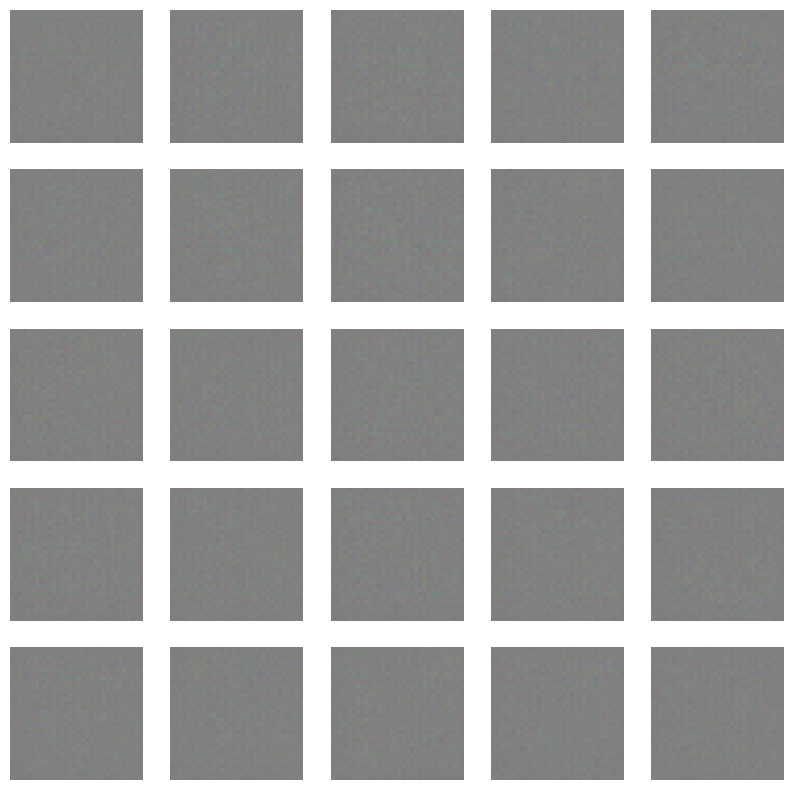

1/1 [==============================] - 0s 16ms/step
epoch: 101/5000, d_loss: 0.62, g_loss: 2.57
1/1 [==============================] - 0s 16ms/step
epoch: 201/5000, d_loss: 0.76, g_loss: 2.37
1/1 [==============================] - 0s 17ms/step


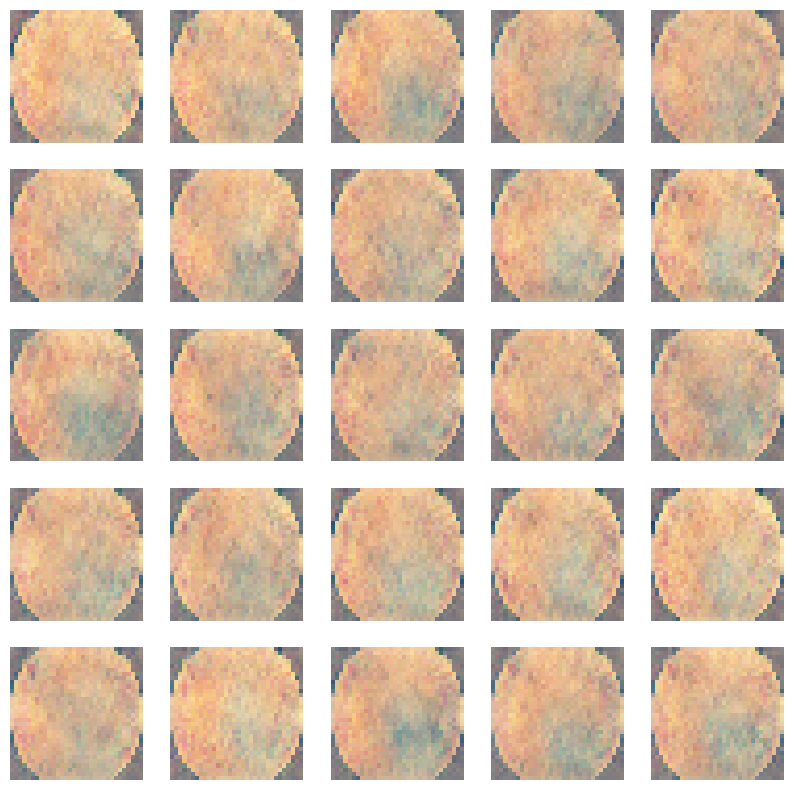

1/1 [==============================] - 0s 17ms/step
epoch: 301/5000, d_loss: 0.72, g_loss: 2.31
1/1 [==============================] - 0s 17ms/step
epoch: 401/5000, d_loss: 0.70, g_loss: 2.27
1/1 [==============================] - 0s 17ms/step


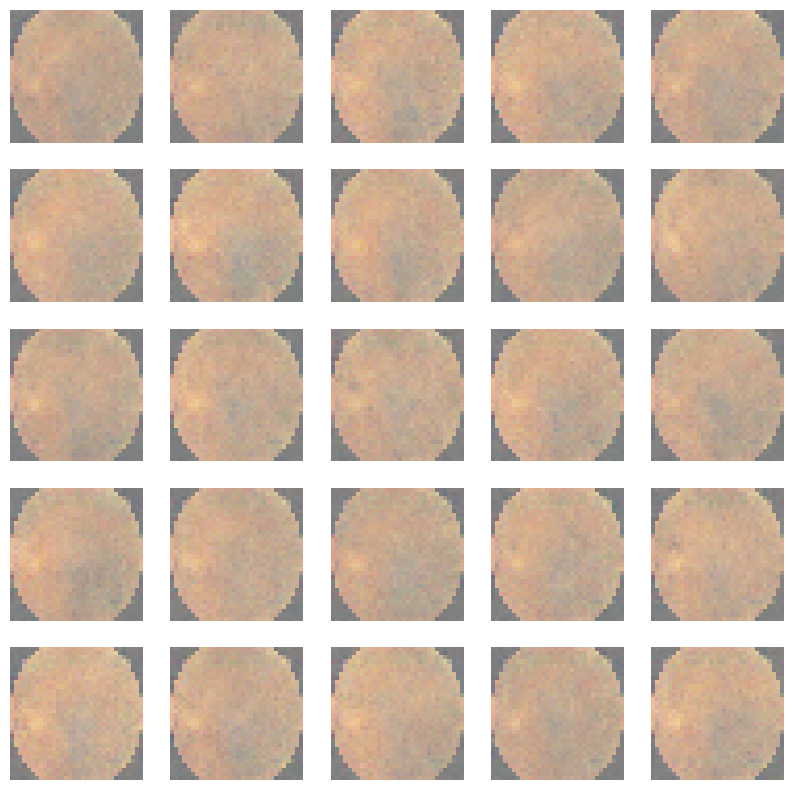

1/1 [==============================] - 0s 16ms/step
epoch: 501/5000, d_loss: 0.69, g_loss: 2.29
1/1 [==============================] - 0s 17ms/step
epoch: 601/5000, d_loss: 0.68, g_loss: 2.26
1/1 [==============================] - 0s 17ms/step


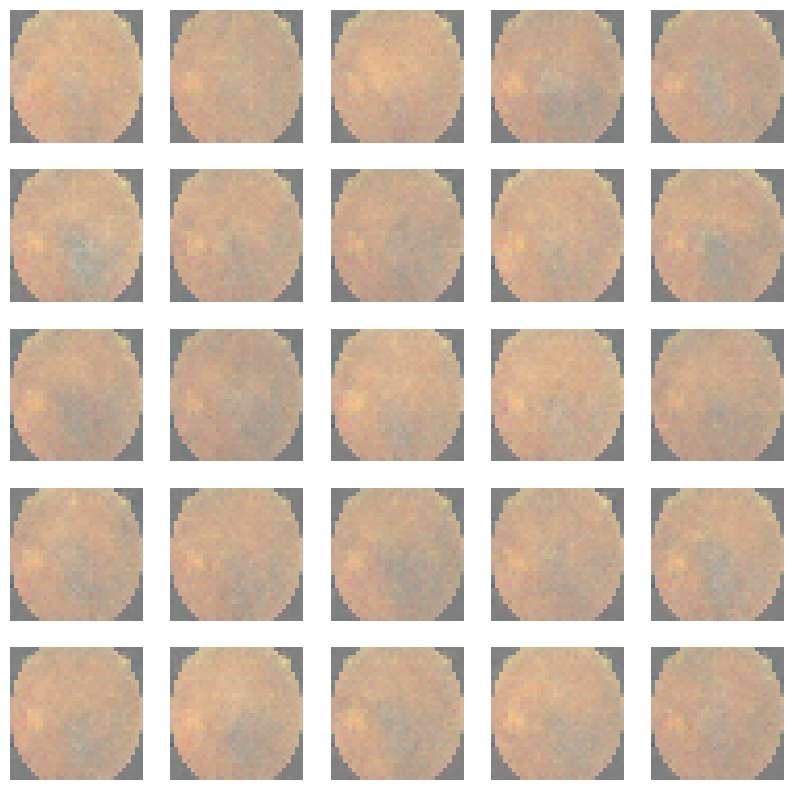

1/1 [==============================] - 0s 28ms/step
epoch: 701/5000, d_loss: 0.71, g_loss: 2.24
1/1 [==============================] - 0s 18ms/step
epoch: 801/5000, d_loss: 0.69, g_loss: 2.25
1/1 [==============================] - 0s 18ms/step


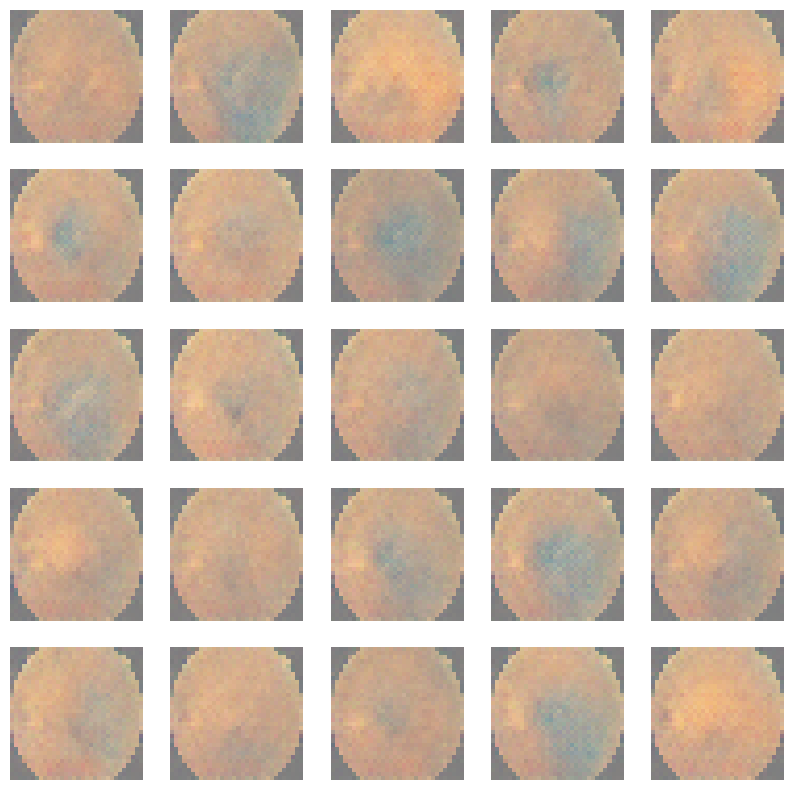

1/1 [==============================] - 0s 28ms/step
epoch: 901/5000, d_loss: 0.68, g_loss: 2.28
1/1 [==============================] - 0s 21ms/step
epoch: 1001/5000, d_loss: 0.68, g_loss: 2.29
1/1 [==============================] - 0s 19ms/step


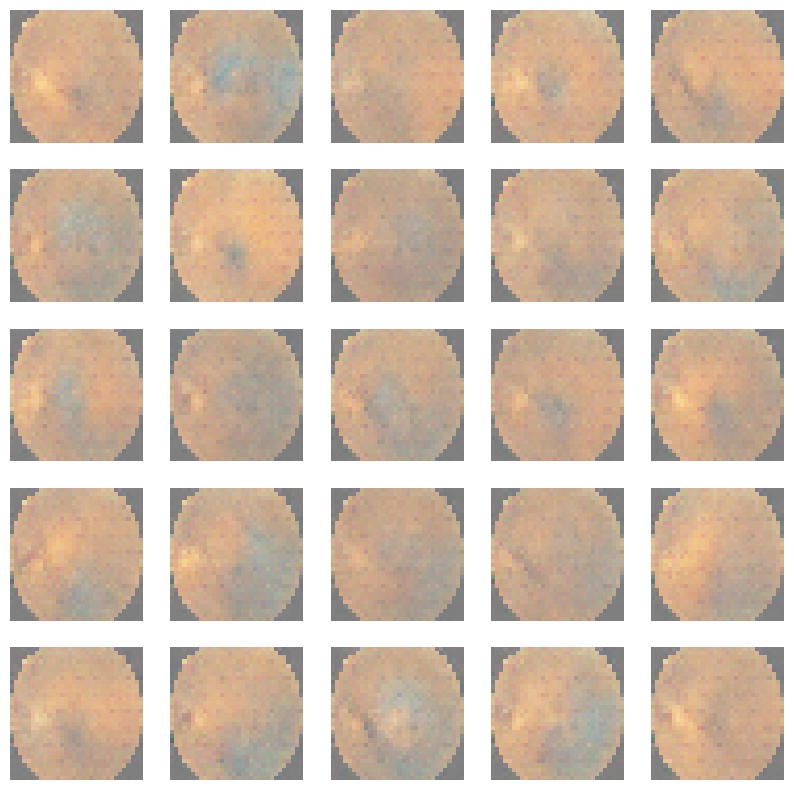

1/1 [==============================] - 0s 16ms/step
epoch: 1101/5000, d_loss: 0.69, g_loss: 2.28
1/1 [==============================] - 0s 16ms/step
epoch: 1201/5000, d_loss: 0.69, g_loss: 2.27
1/1 [==============================] - 0s 20ms/step


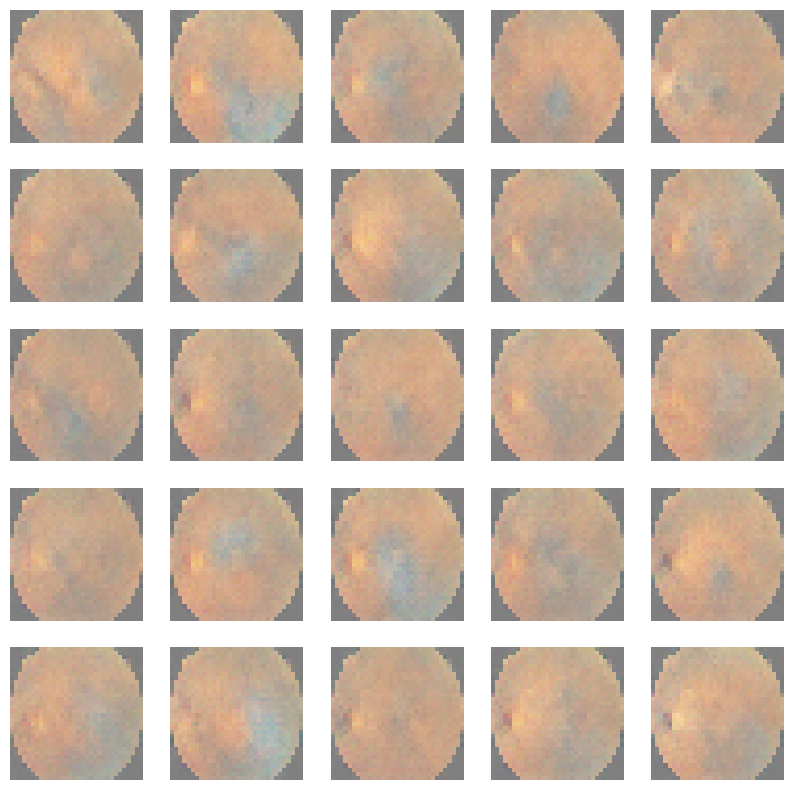

1/1 [==============================] - 0s 38ms/step
epoch: 1301/5000, d_loss: 0.70, g_loss: 2.24
1/1 [==============================] - 0s 17ms/step
epoch: 1401/5000, d_loss: 0.68, g_loss: 2.27
1/1 [==============================] - 0s 19ms/step


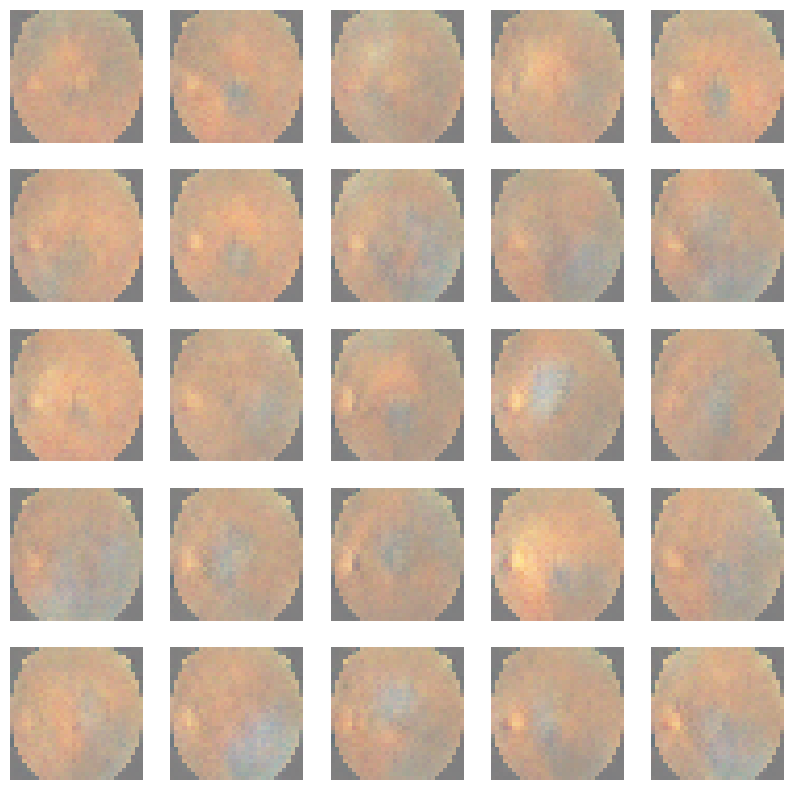

1/1 [==============================] - 0s 17ms/step
epoch: 1501/5000, d_loss: 0.69, g_loss: 2.28
1/1 [==============================] - 0s 17ms/step
epoch: 1601/5000, d_loss: 0.69, g_loss: 2.28
1/1 [==============================] - 0s 20ms/step


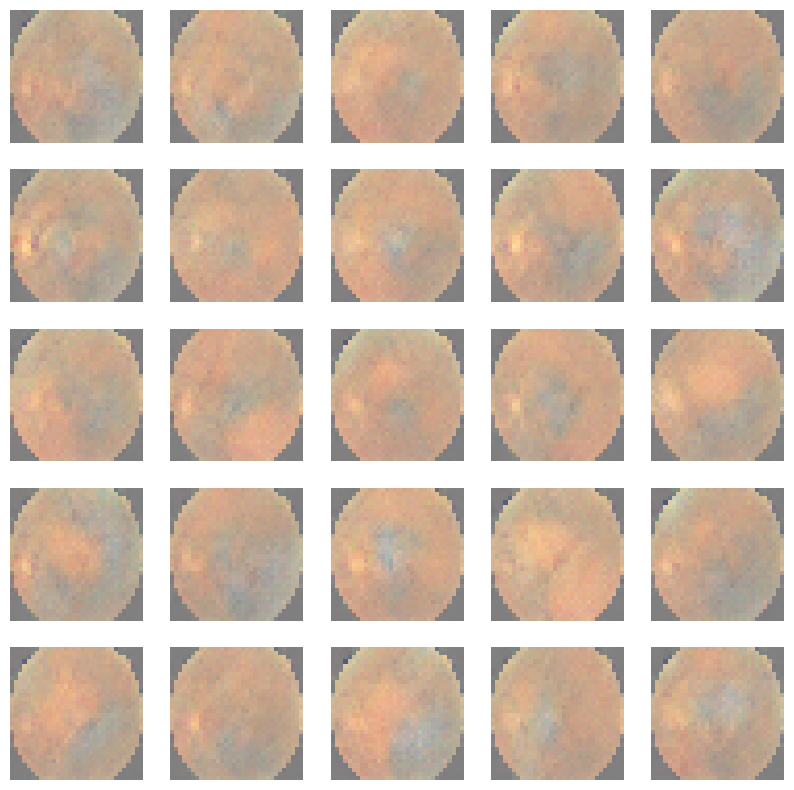

1/1 [==============================] - 0s 27ms/step
epoch: 1701/5000, d_loss: 0.69, g_loss: 2.28
1/1 [==============================] - 0s 18ms/step
epoch: 1801/5000, d_loss: 0.69, g_loss: 2.30
1/1 [==============================] - 0s 18ms/step


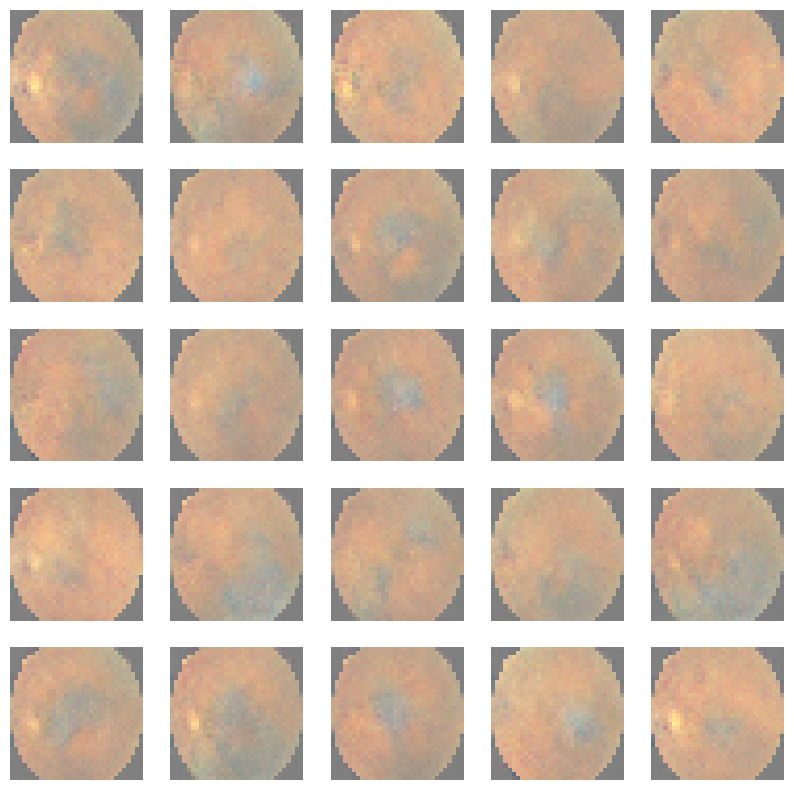

1/1 [==============================] - 0s 17ms/step
epoch: 1901/5000, d_loss: 0.69, g_loss: 2.27
1/1 [==============================] - 0s 18ms/step
epoch: 2001/5000, d_loss: 0.69, g_loss: 2.28
1/1 [==============================] - 0s 20ms/step


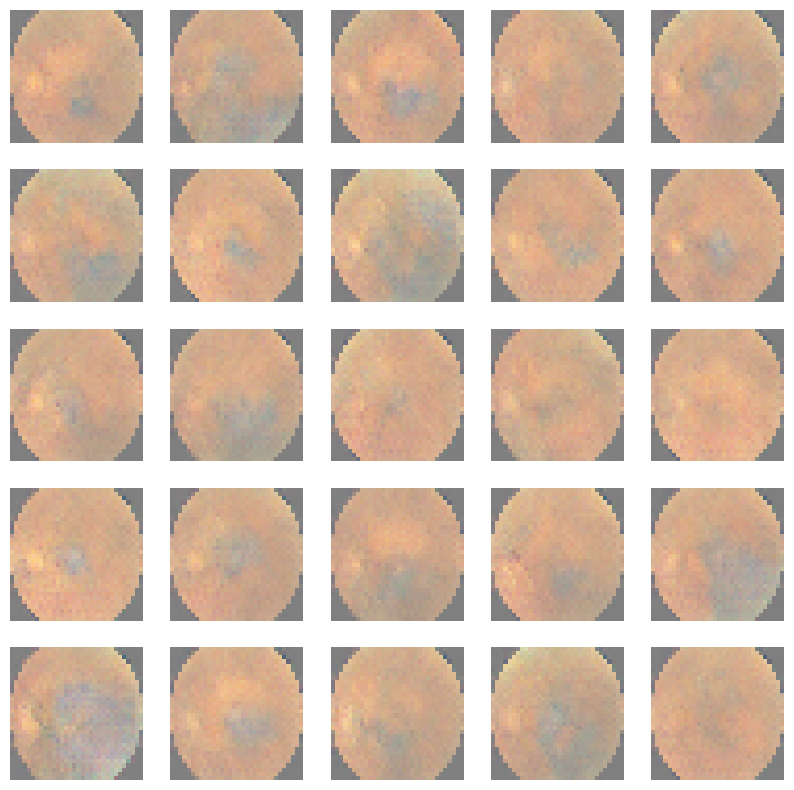

1/1 [==============================] - 0s 17ms/step
epoch: 2101/5000, d_loss: 0.68, g_loss: 2.31
1/1 [==============================] - 0s 16ms/step
epoch: 2201/5000, d_loss: 0.70, g_loss: 2.23
1/1 [==============================] - 0s 20ms/step


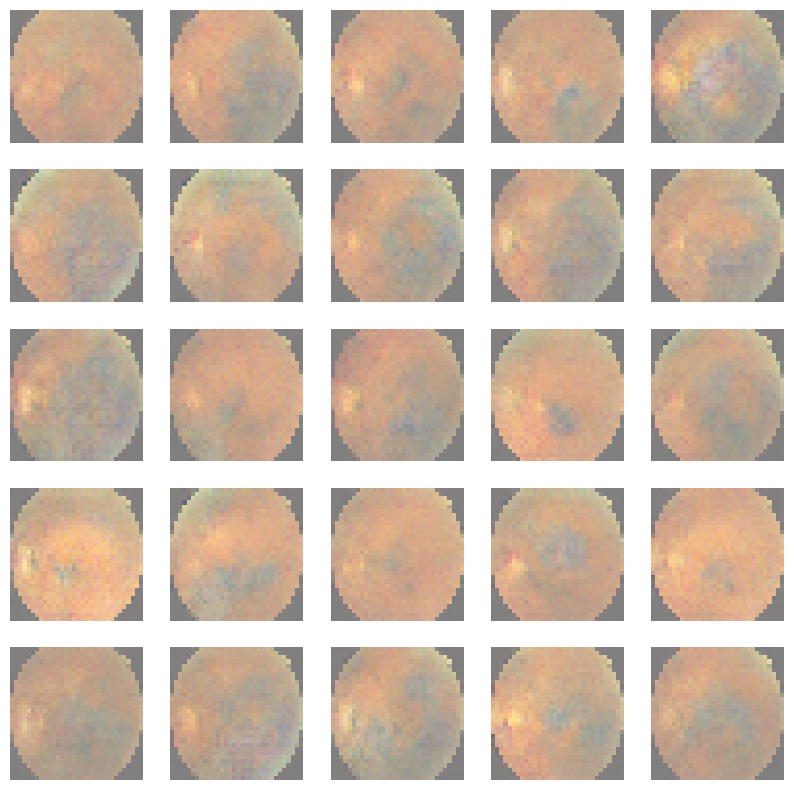

1/1 [==============================] - 0s 28ms/step
epoch: 2301/5000, d_loss: 0.68, g_loss: 2.27
1/1 [==============================] - 0s 34ms/step
epoch: 2401/5000, d_loss: 0.68, g_loss: 2.30
1/1 [==============================] - 0s 30ms/step


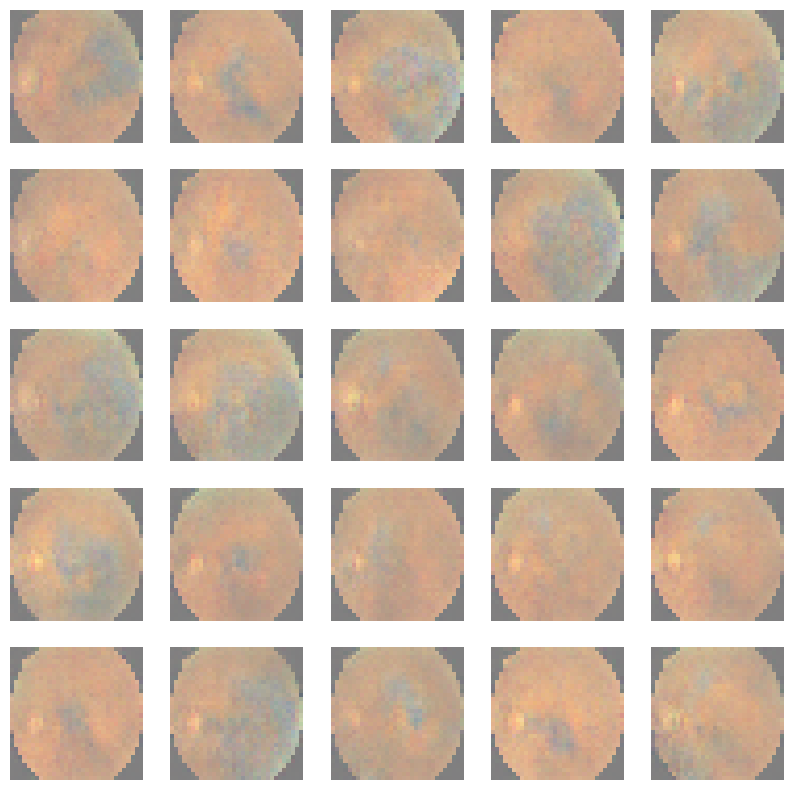

1/1 [==============================] - 0s 32ms/step
epoch: 2501/5000, d_loss: 0.68, g_loss: 2.34
1/1 [==============================] - 0s 25ms/step
epoch: 2601/5000, d_loss: 0.68, g_loss: 2.28
1/1 [==============================] - 0s 35ms/step


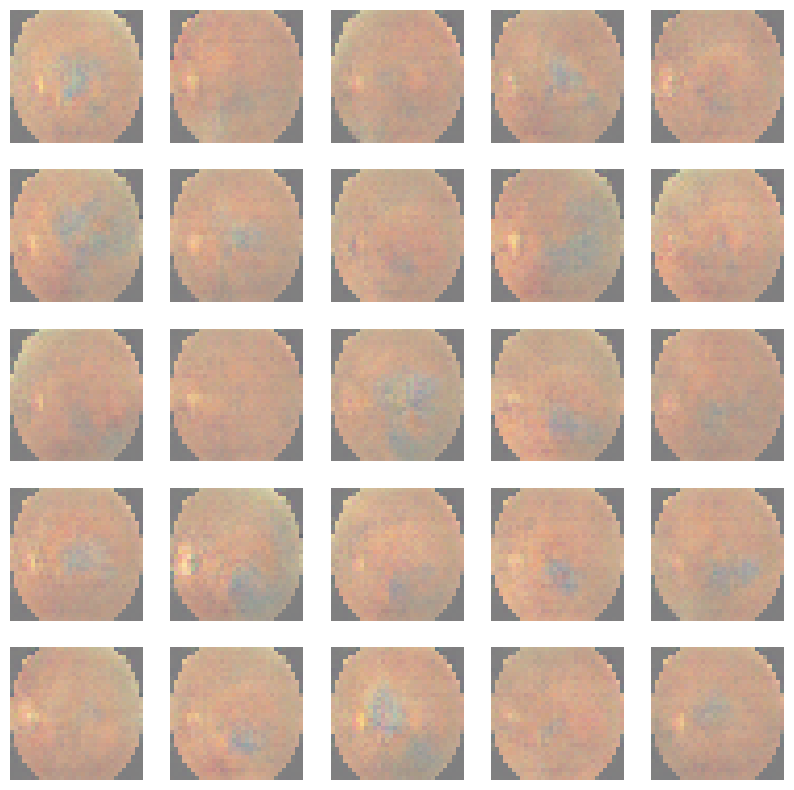

1/1 [==============================] - 0s 18ms/step
epoch: 2701/5000, d_loss: 0.67, g_loss: 2.28
1/1 [==============================] - 0s 20ms/step
epoch: 2801/5000, d_loss: 0.68, g_loss: 2.27
1/1 [==============================] - 0s 33ms/step


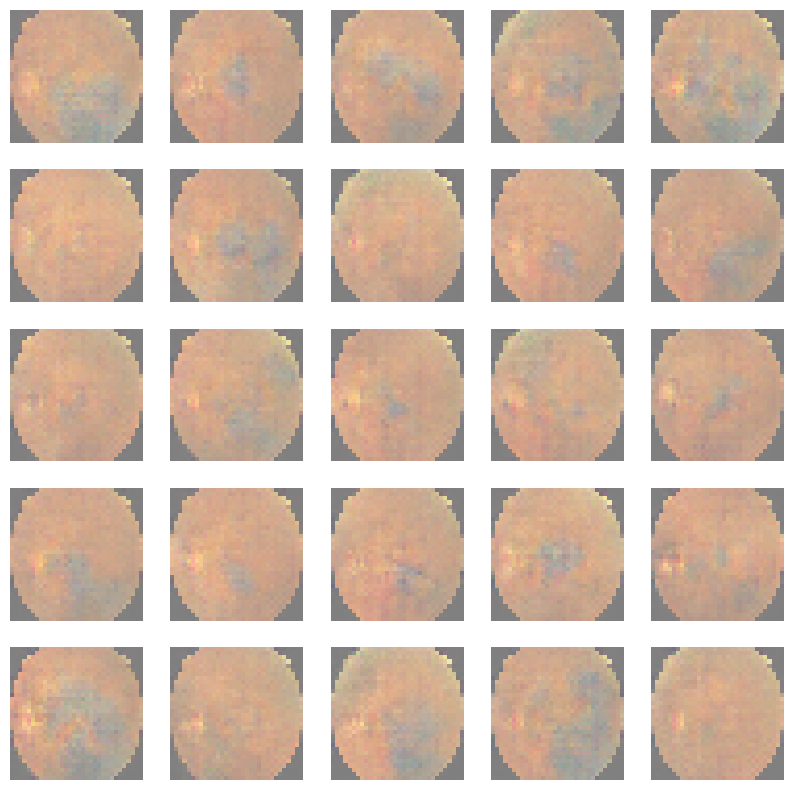

1/1 [==============================] - 0s 18ms/step
epoch: 2901/5000, d_loss: 0.68, g_loss: 2.27
1/1 [==============================] - 0s 20ms/step
epoch: 3001/5000, d_loss: 0.68, g_loss: 2.30
1/1 [==============================] - 0s 21ms/step


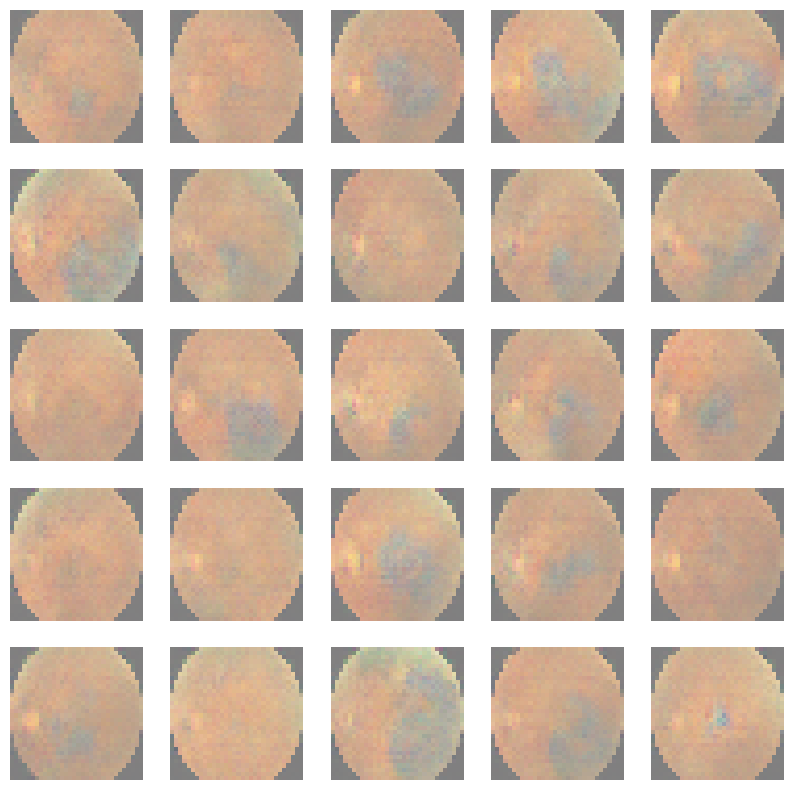

1/1 [==============================] - 0s 19ms/step
epoch: 3101/5000, d_loss: 0.64, g_loss: 2.35
1/1 [==============================] - 0s 17ms/step
epoch: 3201/5000, d_loss: 0.68, g_loss: 2.27
1/1 [==============================] - 0s 36ms/step


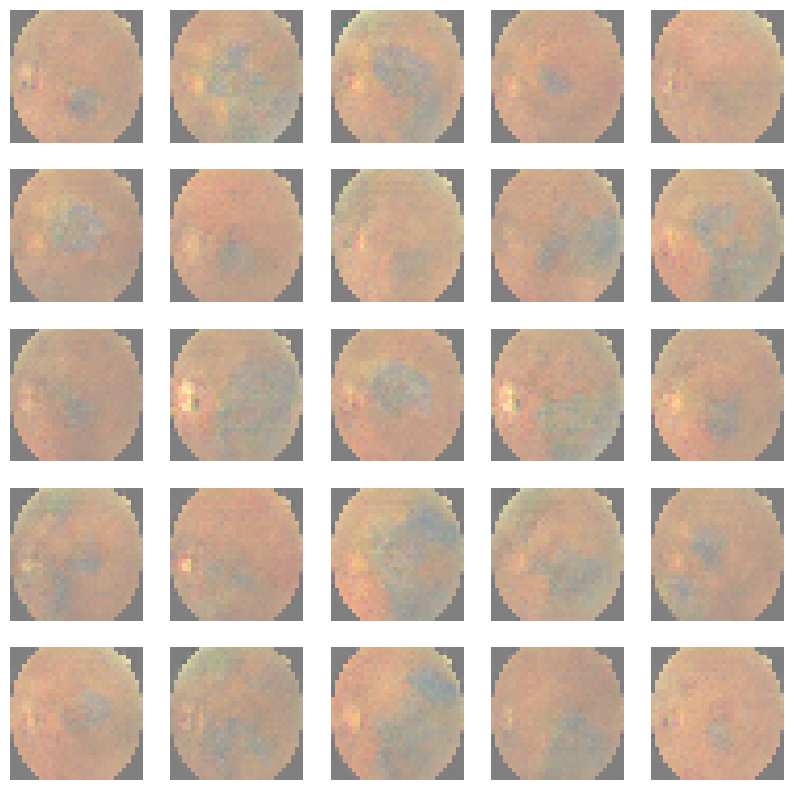

1/1 [==============================] - 0s 19ms/step
epoch: 3301/5000, d_loss: 0.66, g_loss: 2.39
1/1 [==============================] - 0s 17ms/step
epoch: 3401/5000, d_loss: 0.70, g_loss: 2.37
1/1 [==============================] - 0s 22ms/step


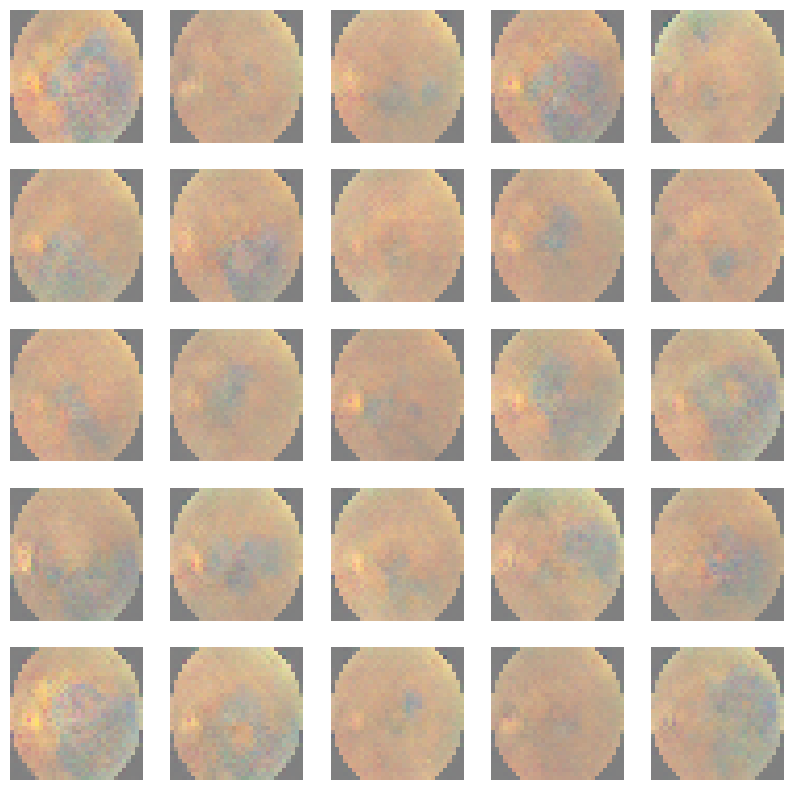

1/1 [==============================] - 0s 19ms/step
epoch: 3501/5000, d_loss: 0.63, g_loss: 2.41
1/1 [==============================] - 0s 16ms/step
epoch: 3601/5000, d_loss: 0.67, g_loss: 2.33
1/1 [==============================] - 0s 21ms/step


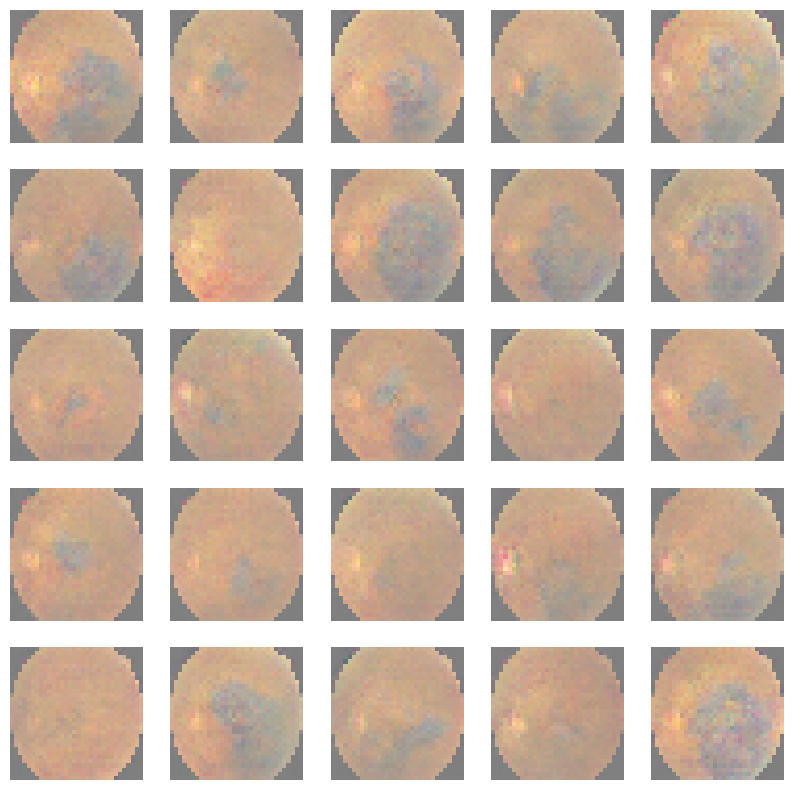

1/1 [==============================] - 0s 19ms/step
epoch: 3701/5000, d_loss: 0.70, g_loss: 2.26
1/1 [==============================] - 0s 17ms/step
epoch: 3801/5000, d_loss: 0.68, g_loss: 2.28
1/1 [==============================] - 0s 18ms/step


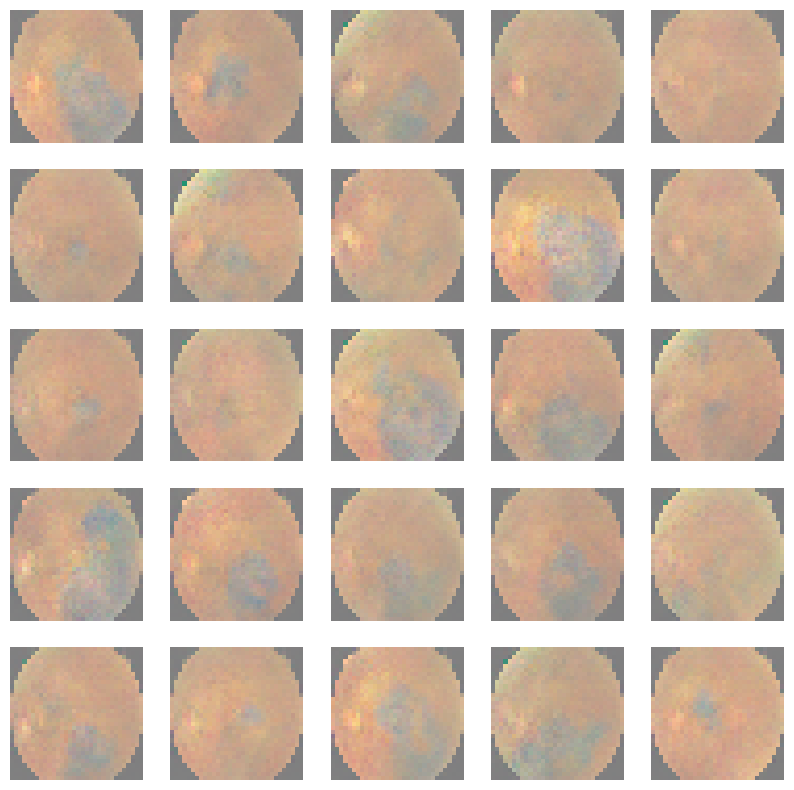

1/1 [==============================] - 0s 20ms/step
epoch: 3901/5000, d_loss: 0.71, g_loss: 2.27
1/1 [==============================] - 0s 16ms/step
epoch: 4001/5000, d_loss: 0.66, g_loss: 2.39
1/1 [==============================] - 0s 19ms/step


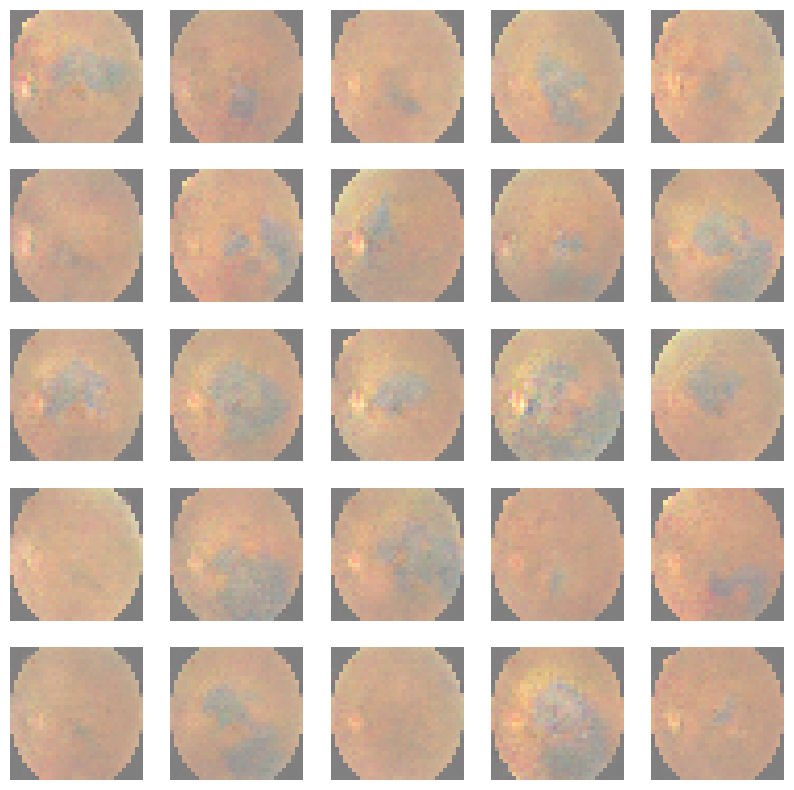

1/1 [==============================] - 0s 20ms/step
epoch: 4101/5000, d_loss: 0.65, g_loss: 2.36
1/1 [==============================] - 0s 20ms/step
epoch: 4201/5000, d_loss: 0.64, g_loss: 2.36
1/1 [==============================] - 0s 17ms/step


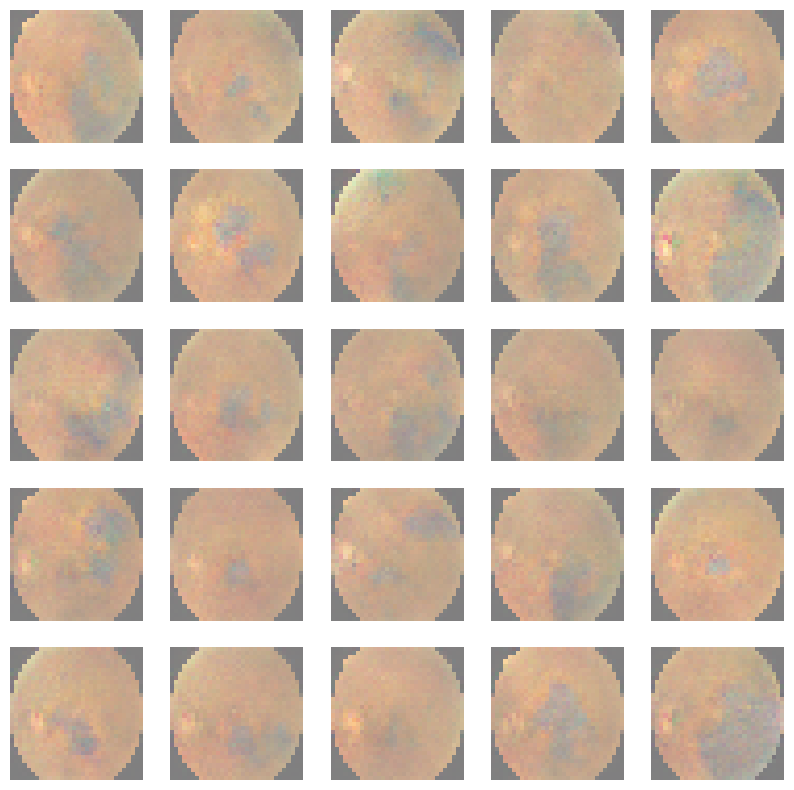

1/1 [==============================] - 0s 17ms/step
epoch: 4301/5000, d_loss: 0.68, g_loss: 2.46
1/1 [==============================] - 0s 20ms/step
epoch: 4401/5000, d_loss: 0.67, g_loss: 2.37
1/1 [==============================] - 0s 21ms/step


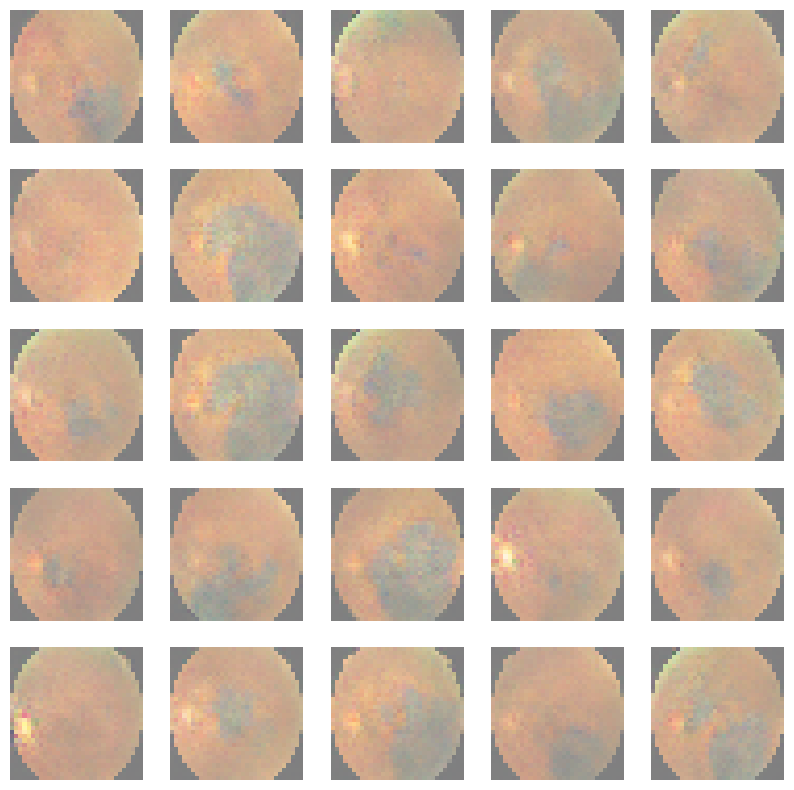

1/1 [==============================] - 0s 20ms/step
epoch: 4501/5000, d_loss: 0.68, g_loss: 2.31
1/1 [==============================] - 0s 20ms/step
epoch: 4601/5000, d_loss: 0.66, g_loss: 2.32
1/1 [==============================] - 0s 23ms/step


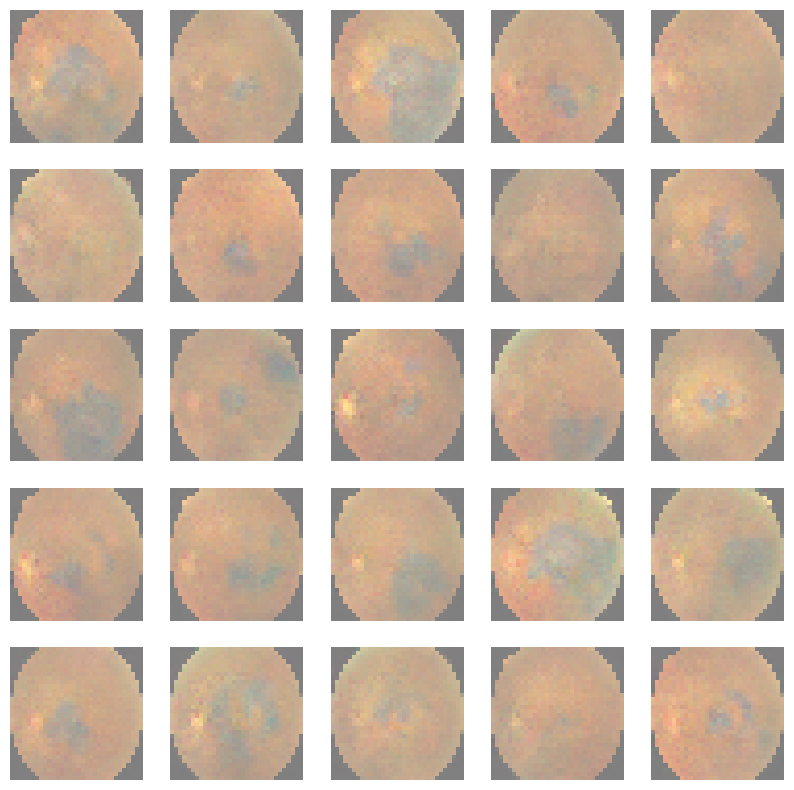

1/1 [==============================] - 0s 18ms/step
epoch: 4701/5000, d_loss: 0.66, g_loss: 2.33
1/1 [==============================] - 0s 18ms/step
epoch: 4801/5000, d_loss: 0.66, g_loss: 2.34
1/1 [==============================] - 0s 21ms/step


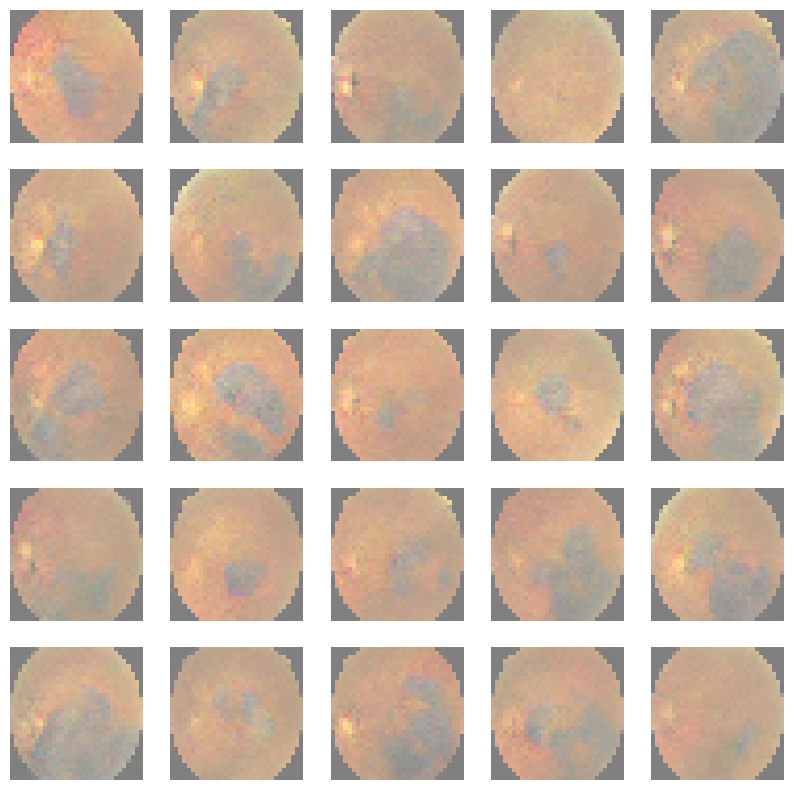

1/1 [==============================] - 0s 21ms/step
epoch: 4901/5000, d_loss: 0.67, g_loss: 2.32
1/1 [==============================] - 0s 19ms/step


In [ ]:
# Training loop
batch_size = 32
epochs = 5000
latent_dim = 128
ones = np.ones(batch_size)
zeros = np.zeros(batch_size)
d_losses = []
g_losses = []
for epoch in range(epochs):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[idx]
    noise = np.random.randn(batch_size, latent_dim)
    fake_imgs = generator.predict(noise)
    d_loss_real, _ = discriminator.train_on_batch(real_imgs, ones)
    d_loss_fake, _ = discriminator.train_on_batch(fake_imgs, zeros)
    d_loss = 0.5 * (d_loss_real + d_loss_fake)
    noise = np.random.randn(batch_size, latent_dim)
    fake = generator.predict(np.random.randn(1, 128))
    g_loss = combined_model_gen.train_on_batch(noise, ones)
    d_losses.append(d_loss)
    g_losses.append(g_loss)
    if epoch % 100 == 0:
        print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f}, g_loss: {g_loss:.2f}")

    if epoch % 200 == 0:
        # Save generated images
        sample_images(epoch)
        rows, cols = 5, 5
        noise = np.random.randn(rows * cols, latent_dim)
        imgs = generator.predict(noise)
        imgs = 0.5 * imgs + 0.5
        fig, axs = plt.subplots(rows, cols, figsize=(10, 10))
        idx = 0
        for i in range(rows):
            for j in range(cols):
                axs[i, j].imshow(imgs[idx])
                axs[i, j].axis('off')
                idx += 1
        plt.show()

In [ ]:
# Saving the Generator Model
generator.save('generator_SAM.h5')

In [ ]:
# Loading the Generator Model
generator = tf.keras.models.load_model('/content/generator_SAM.h5')

1/1 [==============================] - 0s 26ms/step


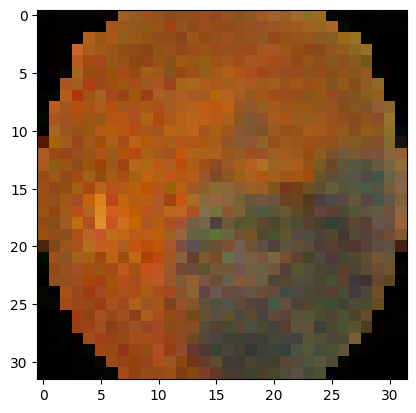

In [ ]:
# Gan output with Spatail Attention Maps
plt.imshow(generator.predict(np.random.randn(1, 128))[0])

1/1 [==============================] - 0s 18ms/step


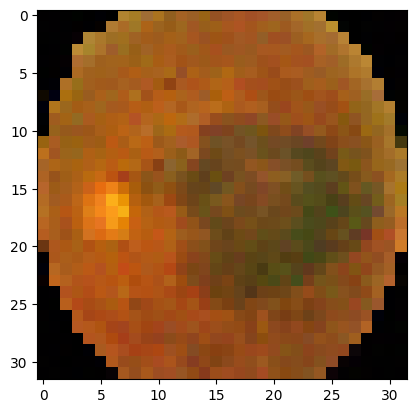

In [ ]:
# Gan output without Spatial Attention Maps
plt.imshow(generator.predict(np.random.randn(1, 128))[0])

In [ ]:
# Generating and Saving AMD Images
noise = np.random.randn(20, 128)
imgs = generator.predict(noise)
for i, image in enumerate(imgs):
    img = Image.fromarray((255 * image).astype(np.uint8))
    img.save(f'gan_images/GAN_Generated_{i}.png')

In [ ]:
!zip -r 'generated_CNVM.zip' '/content/gan_images'

  adding: content/gan_images/ (stored 0%)
  adding: content/gan_images/GAN_Generated_11.png (stored 0%)
  adding: content/gan_images/GAN_Generated_4.png (stored 0%)
  adding: content/gan_images/GAN_Generated_6.png (stored 0%)
  adding: content/gan_images/GAN_Generated_12.png (stored 0%)
  adding: content/gan_images/GAN_Generated_19.png (stored 0%)
  adding: content/gan_images/GAN_Generated_7.png (stored 0%)
  adding: content/gan_images/GAN_Generated_1.png (stored 0%)
  adding: content/gan_images/GAN_Generated_3.png (stored 0%)
  adding: content/gan_images/GAN_Generated_9.png (stored 0%)
  adding: content/gan_images/GAN_Generated_17.png (stored 0%)
  adding: content/gan_images/GAN_Generated_16.png (stored 0%)
  adding: content/gan_images/GAN_Generated_8.png (stored 0%)
  adding: content/gan_images/GAN_Generated_15.png (stored 0%)
  adding: content/gan_images/GAN_Generated_10.png (stored 0%)
  adding: content/gan_images/GAN_Generated_13.png (stored 0%)
  adding: content/gan_images/GAN_Ge